In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

C:\Users\Admin\.conda\envs\yolo5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["PYTHONIOENCODING"] = "gb2312"

In [3]:
# !chcp 65001
# !dir /b /s

In [4]:
data = pd.read_csv('../data/titanic/train_treated.csv')
data.describe(include = 'all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000
mean,0.382889,2.318373,0.346424,29.533310,0.528752,0.391304,31.829552,0.368864
std,0.486433,0.833573,0.476164,13.092235,1.140213,0.820922,50.108026,0.655560
min,0.000000,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000
50%,0.000000,3.000000,0.000000,28.750000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000


In [5]:
# nn记得normalization
for col in data.columns:
    data[col] = data[col]  / data[col].abs().max()

In [6]:
x = data.drop('Survived', axis = 1)
y = data['Survived']
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size = 0.2)

# 批量转成tensor而已，写得比较骚
train_x, test_x, train_y, test_y = map(lambda x:torch.Tensor(x.values), [train_X, test_X, train_Y, test_Y])

In [7]:
train_x.shape

torch.Size([570, 7])

In [8]:
# 随便弄个网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(7, 128)
        self.layer2 = nn.Linear(128, 32)
        self.layer3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return F.softmax(x, dim = 1)

In [9]:
model = Net()
print(model)

Net(
  (layer1): Linear(in_features=7, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=2, bias=True)
)


In [10]:
epochs = 1000
optimizer = optim.SGD(model.parameters(), lr = 0.001)
train_loss = []
train_acc = []
train_auc = []

i = 0

model.train()

for epoch in range(epochs):
    X, real_y = Variable(train_x), Variable(train_y)
    optimizer.zero_grad()
    pred_y = model(X) #此时pred_y 等同于xgb和sklearn内pred_proba
    loss = F.binary_cross_entropy(pred_y[:, 1], real_y)
    loss.backward()
    train_loss.append(loss.data.item())
    optimizer.step()
    pred_class = torch.argmax(pred_y, dim=1)
    cur_acc = accuracy_score(real_y, pred_class)
    prob = pred_y.detach().numpy()[:,1]
    cur_auc = roc_auc_score(real_y, prob)
    train_acc.append(cur_acc)
    train_auc.append(cur_auc)
    if i % 50 == 0:
        print('Step: {}\tLoss: {:.3f}\tCurrent Accuracy: {:.3f}\tCurrent Auc: {:.3f}'.format(i, train_loss[i], train_acc[i], train_auc[i]))
    i += 1

print('Step: {}\tLoss: {:.3f}\tCurrent Accuracy: {:.3f}\tCurrent Auc: {:.3f}'.format(i, train_loss[-1], train_acc[-1], train_auc[-1]))

Step: 0	Loss: 0.726	Current Accuracy: 0.393	Current Auc: 0.739
Step: 50	Loss: 0.717	Current Accuracy: 0.393	Current Auc: 0.745
Step: 100	Loss: 0.710	Current Accuracy: 0.393	Current Auc: 0.754
Step: 150	Loss: 0.704	Current Accuracy: 0.393	Current Auc: 0.768
Step: 200	Loss: 0.698	Current Accuracy: 0.393	Current Auc: 0.783
Step: 250	Loss: 0.692	Current Accuracy: 0.393	Current Auc: 0.794
Step: 300	Loss: 0.687	Current Accuracy: 0.393	Current Auc: 0.800
Step: 350	Loss: 0.683	Current Accuracy: 0.414	Current Auc: 0.804
Step: 400	Loss: 0.679	Current Accuracy: 0.744	Current Auc: 0.806
Step: 450	Loss: 0.675	Current Accuracy: 0.777	Current Auc: 0.807
Step: 500	Loss: 0.672	Current Accuracy: 0.789	Current Auc: 0.809
Step: 550	Loss: 0.668	Current Accuracy: 0.793	Current Auc: 0.809
Step: 600	Loss: 0.665	Current Accuracy: 0.796	Current Auc: 0.810
Step: 650	Loss: 0.663	Current Accuracy: 0.786	Current Auc: 0.810
Step: 700	Loss: 0.660	Current Accuracy: 0.758	Current Auc: 0.810
Step: 750	Loss: 0.657	Curren

In [11]:
model.eval()
test_res = model(Variable(test_x))
roc_auc_score(test_y, test_res.detach().numpy()[:,1])

0.873643074250977

In [12]:
explainer = shap.DeepExplainer(model, torch.Tensor(x.values))
shap_matrix = explainer.shap_values(torch.Tensor(x.values))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


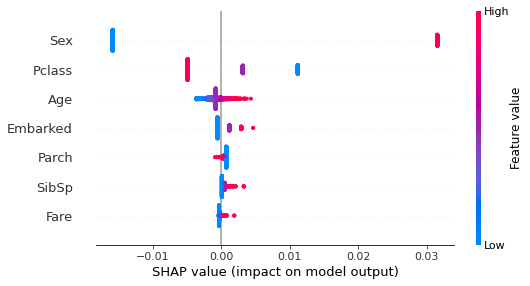

In [13]:
shap.summary_plot(shap_values=shap_matrix[1],
                 features=x,
                 feature_names=x.columns.tolist())

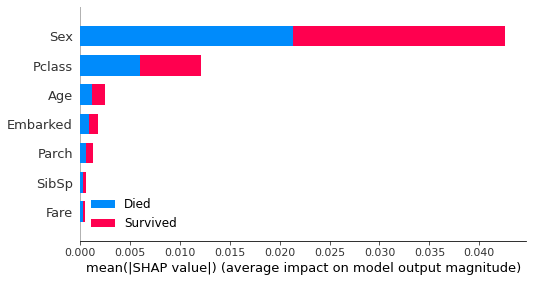

In [14]:
shap.summary_plot(shap_values = shap_matrix,features = x, feature_names=x.columns.tolist(),  plot_type='bar', class_names=['Died', 'Survived'])